# Problem 1: MixUp Cats and Dogs

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.PETS) / 'images'

In [ ]:
def is_cat(x):
    return x[0].isupper()

In [ ]:
dls = ImageDataLoaders.from_name_func(
    path,
    get_image_files(path),
    valid_pct=0.2,
    seed=42,
    label_func=is_cat,
    item_tfms=Resize(224),
    num_workers=0
)

## MixUp

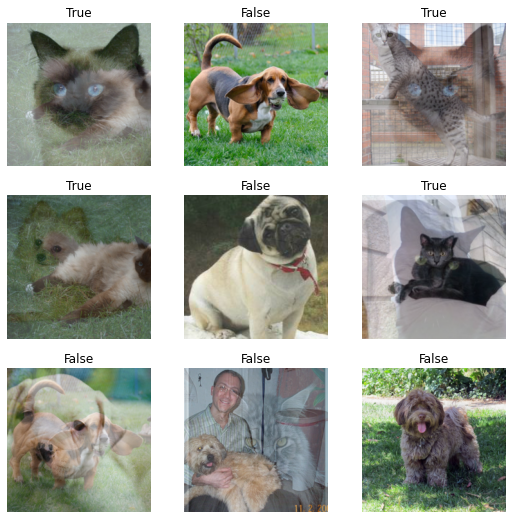

In [ ]:
mixup = MixUp(1.)
with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup) as learn:
    learn.epoch, learn.training = 0, True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_train')
    learn('before_batch')

_, axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(mixup.x,mixup.y), ctxs=axs.flatten())

In [ ]:
learn = cnn_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, error_rate])
learn.fine_tune(10, cbs=mixup)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


## CutMix

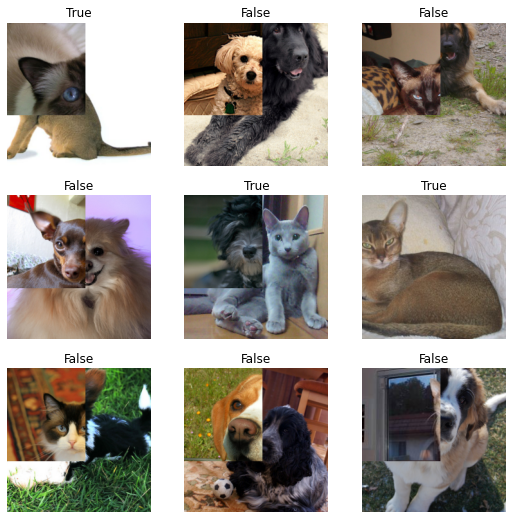

In [ ]:
cutmix = CutMix(1.)
with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=cutmix) as learn:
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_train')
    learn('before_batch')

_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(cutmix.x,cutmix.y), ctxs=axs.flatten())

In [ ]:
learn = cnn_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, error_rate])
learn.fine_tune(10, cbs=cutmix)

## Interpretation of the results

- The performance of resnet18 architecture without any data augmentation techniques was discussed in the textbook and the error rate was around 0.002-0.005.
- As we see from the charts above, CutMix and MixUp do not really improve the performance.
- The above data augmentation techniques provide significant performance boost if we have a small dataset or we do not have a pretrained model. This is not the case in our example, therefore, we see no improvements.

# Problem 2: Data Augmentation

In [ ]:
from PIL import Image, ImageOps
import requests
from torchvision import transforms

In [ ]:
image_url = 'https://drive.google.com/uc?export=view&id=11uGwACUiacuJfRqSM7dnQ5zcJcm10fFo'
image = Image.open(requests.get(image_url, stream=True).raw)

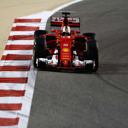

In [ ]:
# Resize to 128x128
image.resize((128, 128))

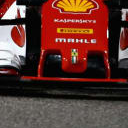

In [ ]:
# Center crop
transforms.CenterCrop((128, 128)).forward(image)

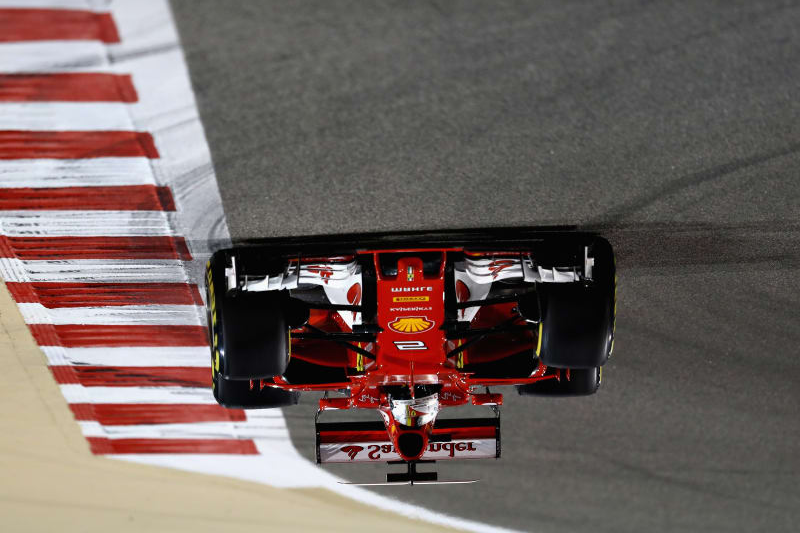

In [ ]:
# Vertical flip
transforms.RandomVerticalFlip(p=1).forward(image)

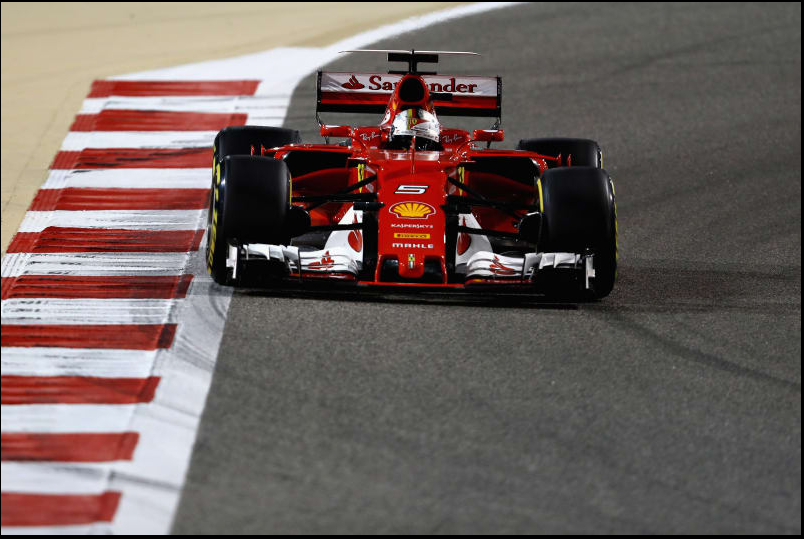

In [ ]:
# Apply padding
transforms.Pad((1, 2, 3, 4)).forward(image)

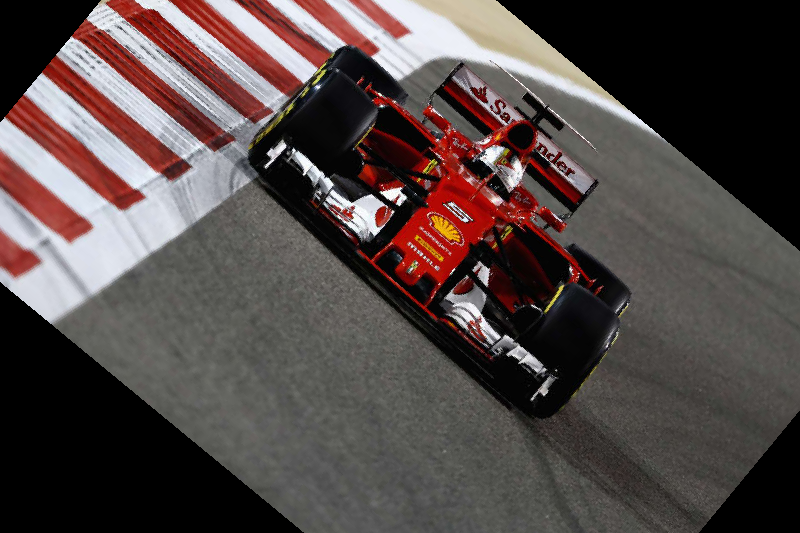

In [ ]:
# Rotation
transforms.RandomRotation(45).forward(image)

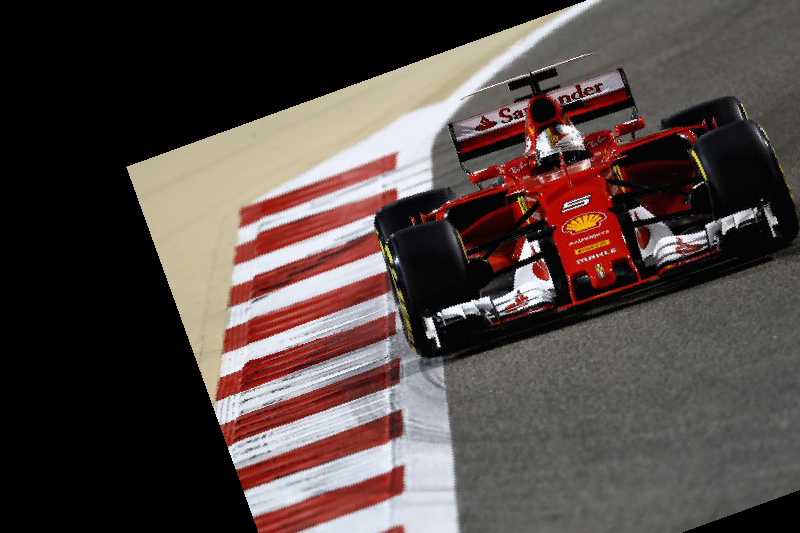

In [ ]:
# Random affine transformation with translate=(0.4, 0.5)
transforms.RandomAffine(45, translate=(0.4, 0.5)).forward(image)

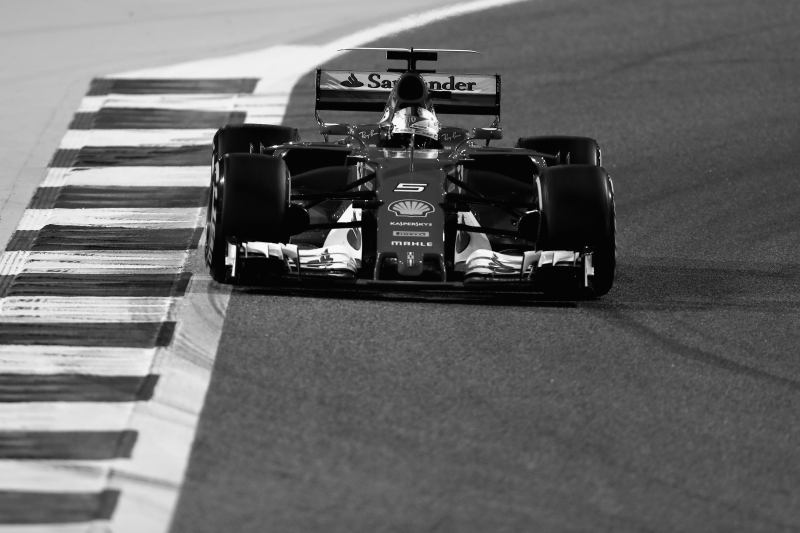

In [ ]:
ImageOps.grayscale(image)

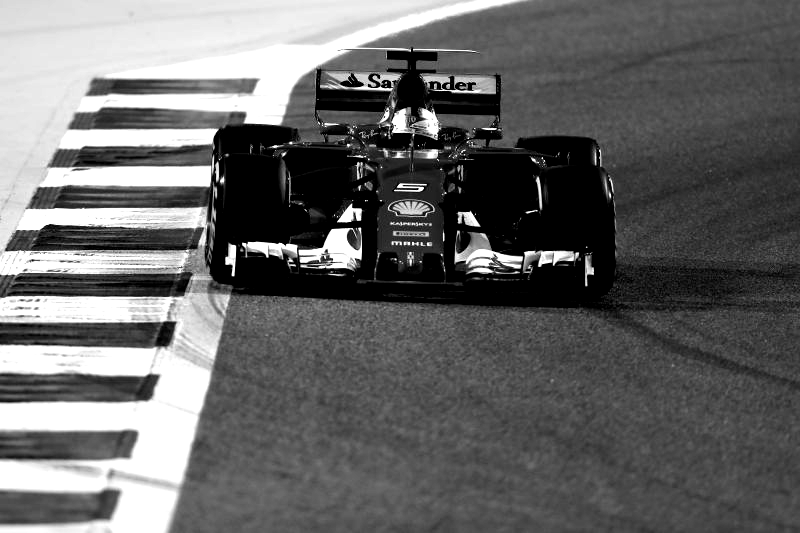

In [ ]:
transforms.ColorJitter(contrast=0.9).forward(ImageOps.grayscale(image))

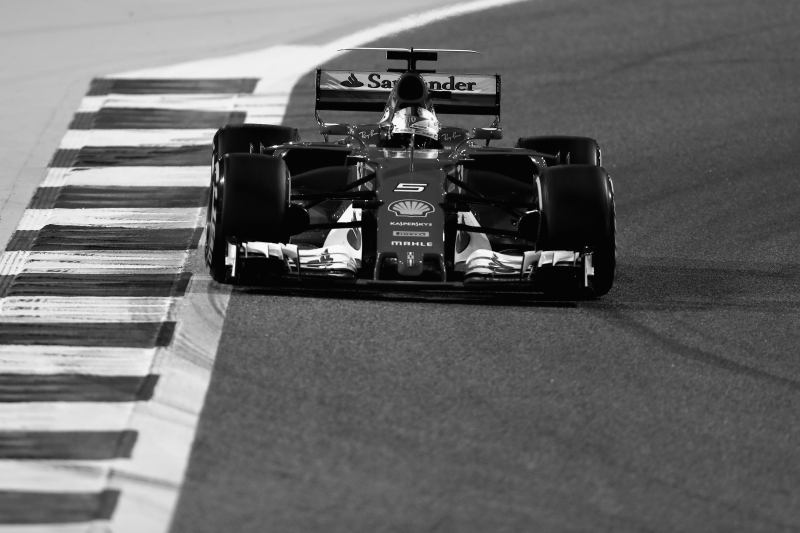

In [ ]:
transforms.ColorJitter(hue=0.5).forward(ImageOps.grayscale(image))

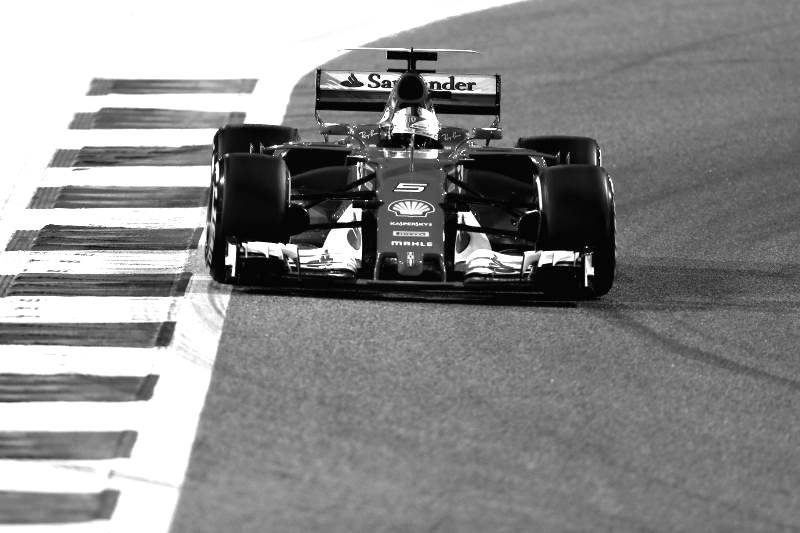

In [ ]:
transforms.ColorJitter(brightness=0.6).forward(ImageOps.grayscale(image))

# Problem 3: MNIST Sample

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.MNIST)

In [ ]:
path.ls()

(#2) [Path('/Users/lberelidze/.fastai/data/mnist_png/training'),Path('/Users/lberelidze/.fastai/data/mnist_png/testing')]

In [ ]:
fours = (path / 'training' / '4').ls().sorted()
nines = (path / 'training' / '9').ls().sorted()

In [ ]:
Image.open(fours[1])

In [ ]:
Image.open(nines[2])

In [ ]:
train_4_tens = torch.stack([tensor(Image.open(o)) for o in (path/'training'/'4').ls()])
train_4_tens = train_4_tens.float()/255
train_9_tens = torch.stack([tensor(Image.open(o)) for o in (path/'training'/'9').ls()])
train_9_tens = train_9_tens.float()/255

In [ ]:
valid_4_tens = torch.stack([tensor(Image.open(o)) for o in (path/'testing'/'4').ls()])
valid_4_tens = valid_4_tens.float()/255
valid_9_tens = torch.stack([tensor(Image.open(o)) for o in (path/'testing'/'9').ls()])
valid_9_tens = valid_9_tens.float()/255

In [ ]:
train_x = torch.cat([train_4_tens, train_9_tens]).view(-1, 28 * 28)
train_y = tensor([1] * len(train_4_tens) + [0] * len(train_9_tens)).unsqueeze(1)
dset = list(zip(train_x,train_y))

In [ ]:
valid_x = torch.cat([valid_4_tens, valid_9_tens]).view(-1, 28 * 28)
valid_y = tensor([1] * len(valid_4_tens) + [0] * len(valid_9_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [ ]:
dl = DataLoader(dset, batch_size=256)

In [ ]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [ ]:
dls = DataLoaders(dl, valid_dl)

In [ ]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [ ]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) == yb
    return correct.float().mean()

In [ ]:
def train(activation):
    simple_net = nn.Sequential(
        nn.Linear(28 * 28, 30),
        activation,
        nn.Linear(30, 1)
    )
    learn = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)
    print(activation.__class__.__name__)
    learn.fit(40, 0.1)

In [ ]:
train(nn.ReLU())

ReLU


In [ ]:
train(nn.Sigmoid())

Sigmoid


In [ ]:
train(nn.Tanh())

Tanh


In [ ]:
train(nn.LeakyReLU())

LeakyReLU


In [ ]:
train(nn.ELU())

ELU


In [ ]:
class Swish(nn.Module):
        def __init__(self, b = 1.):
            super(Swish, self).__init__()
            self.b = b

        def forward(self, x):
            sigmoid = torch.sigmoid(x) ** self.b
            return x * sigmoid

In [ ]:
train(Swish())

Swish


# Problem 4: Bear Multi-Label Classication

In [ ]:
from fastbook import *

### Load images

- NOTE: For convenience, the images searched using Bing API were uploaded to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = Path('./drive/MyDrive/ml-data/bears')
other_path = Path('./drive/MyDrive/ml-data/no-bears')

In [ ]:
path.ls()

(#3) [Path('drive/MyDrive/ml-data/bears/grizzly'),Path('drive/MyDrive/ml-data/bears/black'),Path('drive/MyDrive/ml-data/bears/teddy')]

In [ ]:
other_path.ls()

(#3) [Path('drive/MyDrive/ml-data/no-bears/car'),Path('drive/MyDrive/ml-data/no-bears/dog'),Path('drive/MyDrive/ml-data/no-bears/building')]

### Standard model

In [ ]:
get_image_files(path)

(#416) [Path('drive/MyDrive/ml-data/bears/grizzly/00000000.jpg'),Path('drive/MyDrive/ml-data/bears/grizzly/00000002.jpg'),Path('drive/MyDrive/ml-data/bears/grizzly/00000004.jpg'),Path('drive/MyDrive/ml-data/bears/grizzly/00000003.jpg'),Path('drive/MyDrive/ml-data/bears/grizzly/00000012.jpg'),Path('drive/MyDrive/ml-data/bears/grizzly/00000007.jpg'),Path('drive/MyDrive/ml-data/bears/grizzly/00000011.jpg'),Path('drive/MyDrive/ml-data/bears/grizzly/00000013.jpg'),Path('drive/MyDrive/ml-data/bears/grizzly/00000010.jpg'),Path('drive/MyDrive/ml-data/bears/grizzly/00000009.jpg')...]

In [ ]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=23),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = bears.dataloaders(path)

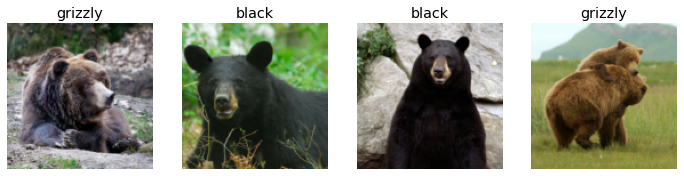

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

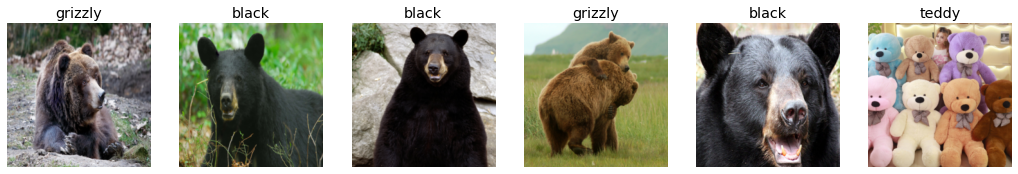

In [ ]:
dls.valid.show_batch(max_n=6, nrows=1)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


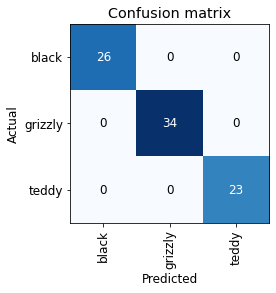

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Test the model for images that do not contain bears

In [ ]:
import random
from PIL import Image

In [ ]:
def pick_random_bear(cls):
  images = (path / cls).ls()
  idx = random.randint(0, len(images) - 1)
  return str(images[idx])

In [ ]:
def pick_random_no_bear(cls):
  images = (other_path / cls).ls()
  idx = random.randint(0, len(images) - 1)
  return str(images[idx])

### Show probabilities

In [ ]:
rand_dog = pick_random_no_bear('dog')

In [ ]:
pred, pred_idx, probs = learn.predict(rand_dog)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: teddy; Probability: 0.7904')

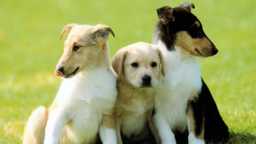

In [ ]:
rand_dog_img = Image.open(rand_dog)
rand_dog_img.to_thumb(256)

### Multi-label Classification

In [ ]:
import pandas as pd

In [ ]:
def create_df():
  rows = []

  for child_path in path.ls():
    label = child_path.name
    for img_path in child_path.ls():
      rows.append([img_path, label])

  for child_path in other_path.ls():
    for img_path in child_path.ls():
      rows.append([img_path, 'none'])

  random.shuffle(rows)
  return pd.DataFrame(rows, columns=['path', 'labels'])

In [ ]:
df = create_df()

In [ ]:
df.head()

path   labels
0                drive/MyDrive/ml-data/bears/grizzly/00000127.jpg  grizzly
1                  drive/MyDrive/ml-data/bears/teddy/00000015.jpg    teddy
2                 drive/MyDrive/ml-data/no-bears/car/00000033.jpg     none
3                  drive/MyDrive/ml-data/bears/black/00000085.jpg    black
4  drive/MyDrive/ml-data/bears/teddy/00000141.jpg?c=2&imbypass=on    teddy

In [ ]:
def get_x(r): return r['path']
def get_y(r): return r['labels'].split(' ') if r['labels'] != 'none' else []

In [ ]:
bears = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock), 
    splitter=RandomSplitter(valid_pct=0.2, seed=23),
    get_x=get_x,
    get_y=get_y,
    item_tfms=RandomResizedCrop(224, min_scale=0.5))
dls = bears.dataloaders(df)

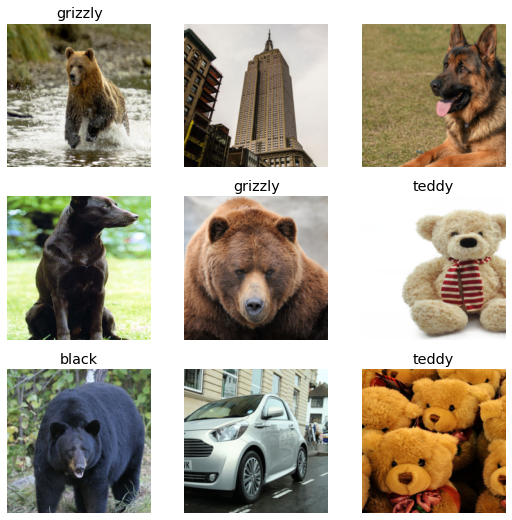

In [ ]:
dls.show_batch(nrows=3, ncols=3)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.8))
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


### Interpret multi-label model prediction results

In [ ]:
rand_car = pick_random_no_bear('car')

In [ ]:
learn.predict(rand_car)

((#0) [], tensor([False, False, False]), tensor([0.0637, 0.0354, 0.0207]))

In [ ]:
rand_dog = pick_random_no_bear('dog')
learn.predict(rand_dog)

((#0) [], tensor([False, False, False]), tensor([0.0432, 0.0370, 0.0079]))

In [ ]:
rand_grizzly = pick_random_bear('grizzly')
learn.predict(rand_grizzly)

((#1) ['grizzly'],
 tensor([False,  True, False]),
 tensor([3.1993e-02, 1.0000e+00, 6.2103e-04]))

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
learn.predict(dls.valid_ds[4][0])

((#1) ['grizzly'],
 tensor([False,  True, False]),
 tensor([3.9235e-04, 1.0000e+00, 1.6595e-03]))

In [ ]:
dls.valid_ds[4]

(PILImage mode=RGB size=1910x1000, TensorMultiCategory([0., 1., 0.]))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

In [ ]:
labels = ['black', 'grizzly', 'teddy', 'other']

In [ ]:
def find_index(t):
    for i, e in enumerate(t):
      if e:
        return i
    return len(t)

In [ ]:
def get_pred_stats():
  y_true = []
  y_pred = []
  for item in dls.valid_ds:
    _, pred, _ = learn.predict(item[0])
    true_idx = find_index(item[1])
    pred_idx = find_index(pred)
    y_true.append(true_idx)
    y_pred.append(pred_idx)
  return y_true, y_pred

In [ ]:
y_true, y_pred = get_pred_stats()

In [ ]:
conf_m = confusion_matrix(y_true, y_pred, range(4))
conf_m

array([[34,  1,  0,  0],
       [ 1, 28,  0,  0],
       [ 0,  0, 22,  0],
       [ 3,  1,  0, 85]])

In [ ]:
df_conf_m = pd.DataFrame(conf_m, labels, labels)

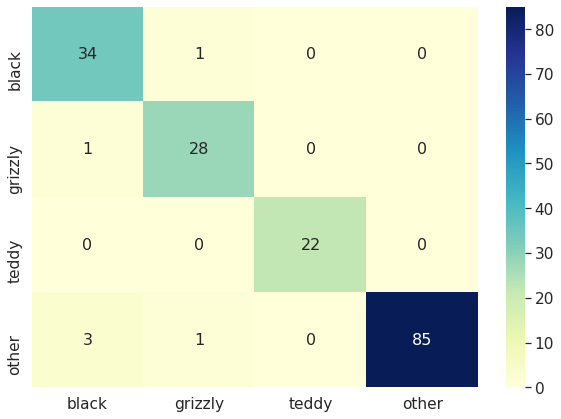

In [ ]:
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_conf_m, annot=True, annot_kws={"size": 16}, cmap='YlGnBu')
plt.show()

# Problem 5: Collaborative Filtering

In [ ]:
import numpy as np
import pandas as pd
from fastai.tabular import *
from fastai.collab import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = './drive/MyDrive/ml-data/songsDataset.csv'

In [ ]:
df = pd.read_csv(file_path, header=0, names=['userId', 'songId', 'rating'])
df.head()

userId  songId  rating
0       0    7171       5
1       0    8637       4
2       0   21966       4
3       0   35821       5
4       0   82446       5

In [ ]:
dls = CollabDataLoaders.from_df(df, valid_pct=0.2)

In [ ]:
dls.show_batch()

In [ ]:
df['rating'].min(), df['rating'].max()

(1, 5)

In [ ]:
y_range = [0.5, 5.5]

In [ ]:
learn = collab_learner(dls, n_factors=30, y_range=y_range)

In [ ]:
learn.fit_one_cycle(5, 0.005)

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=2.2908675418875646e-06)

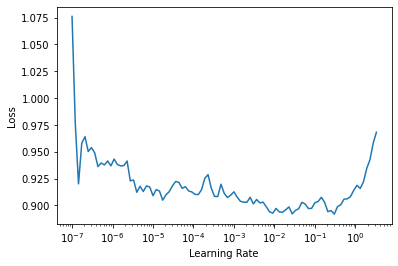

In [ ]:
learn.lr_find()

In [ ]:
for n_factors in [5, 10, 20, 30]:
    print(f'n_factors = {n_factors}')
    learn = collab_learner(dls, n_factors=n_factors, y_range=y_range)
    learn.fit_one_cycle(5, 3e-2)

n_factors = 5


n_factors = 10


n_factors = 20


n_factors = 30


# Problem 6: Random Forest for Tabular Data

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('./data/petrol_consumption.csv')

In [ ]:
df.head()

Petrol_tax  Average_income  Paved_Highways  Population_Driver_licence(%)  \
0         9.0            3571            1976                         0.525   
1         9.0            4092            1250                         0.572   
2         9.0            3865            1586                         0.580   
3         7.5            4870            2351                         0.529   
4         8.0            4399             431                         0.544   

   Petrol_Consumption  
0                 541  
1                 524  
2                 561  
3                 414  
4                 410

### Split the dataset

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df.iloc[:, 0:4].values
y = df.iloc[:, 4].values

Use 'random_state' parameter to obtain reproducible output across multiple function calls:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Scale the dataset

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train = scaler.fit_transform(X_train)

In [ ]:
X_test = scaler.transform(X_test)

### Train the model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [ ]:
rf = RandomForestRegressor(n_estimators=200, random_state=0)

In [ ]:
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=0)

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 48.33899999999999
Mean Squared Error: 3494.2330150000003
Root Mean Squared Error: 59.112037818028234


In [ ]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

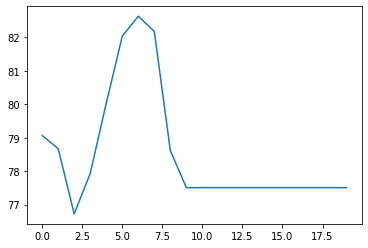

In [ ]:
plt.plot([r_mse(y_pred[:i+1].mean(0), y_test) for i in range(20)])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
importances = rf.feature_importances_

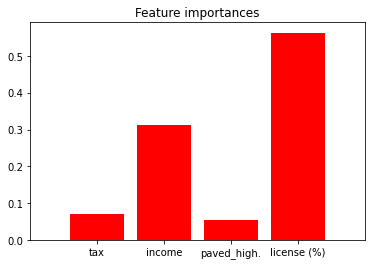

In [ ]:
indices = [0, 1, 2, 3]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), ['tax', 'income', 'paved_high.', 'license (%)'])
plt.xlim([-1, X.shape[1]])
plt.show()

The 'Population_Driver_licence(%)' turns out to be the most important variable.

# Problem 7: Building an GRU from Scratch 

In [ ]:
from fastai import *
from fastai.text.all import *
from fastai.text import *

### Data preparation

In [ ]:
path = untar_data(URLs.HUMAN_NUMBERS)

In [ ]:
path.ls()

(#2) [Path('/Users/lberelidze/.fastai/data/human_numbers/train.txt'),Path('/Users/lberelidze/.fastai/data/human_numbers/valid.txt')]

In [ ]:
lines = L()
with open(path/'train.txt') as f: lines += L(*f.readlines())
with open(path/'valid.txt') as f: lines += L(*f.readlines())
lines

(#9998) ['one \n','two \n','three \n','four \n','five \n','six \n','seven \n','eight \n','nine \n','ten \n'...]

In [ ]:
text = ' . '.join([l.strip() for l in lines])
text[:100]

'one . two . three . four . five . six . seven . eight . nine . ten . eleven . twelve . thirteen . fo'

In [ ]:
tokens = text.split(' ')
tokens[:10]

['one', '.', 'two', '.', 'three', '.', 'four', '.', 'five', '.']

In [ ]:
vocab = L(*tokens).unique()
vocab

(#30) ['one','.','two','three','four','five','six','seven','eight','nine'...]

In [ ]:
word2idx = {w:i for i,w in enumerate(vocab)}
nums = L(word2idx[i] for i in tokens)
nums

(#63095) [0,1,2,1,3,1,4,1,5,1...]

In [ ]:
bs = 64

In [ ]:
def group_chunks(ds, bs):
    m = len(ds) // bs
    new_ds = L()
    for i in range(m): new_ds += L(ds[i + m*j] for j in range(bs))
    return new_ds

In [ ]:
sl = 16
seqs = L((tensor(nums[i:i+sl]), tensor(nums[i+1:i+sl+1])) for i in range(0,len(nums)-sl-1,sl))
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(
    group_chunks(seqs[:cut], bs),
    group_chunks(seqs[cut:], bs),
    bs=bs,
    drop_last=True,
    shuffle=False
)

### LSTM 

In [ ]:
class LMModel7(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers, p):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.drop = nn.Dropout(p)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h_o.weight = self.i_h.weight
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]

    def forward(self, x):
        raw,h = self.rnn(self.i_h(x), self.h)
        out = self.drop(raw)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(out),raw,out

    def reset(self):
        for h in self.h: h.zero_()

In [ ]:
learn = TextLearner(dls, LMModel7(len(vocab), 64, 2, 0.4),
    loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [ ]:
learn.fit_one_cycle(15, 1e-2, wd=0.1)

### GRU

In [ ]:
class GRUModel(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers, p):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.GRU(n_hidden, n_hidden, n_layers, batch_first=True)
        self.drop = nn.Dropout(p)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h_o.weight = self.i_h.weight
        self.h = torch.zeros(n_layers, bs, n_hidden)

    def forward(self, x):
        raw,h = self.rnn(self.i_h(x), self.h)
        out = self.drop(raw)
        self.h = h.detach()
        return self.h_o(out),raw,out

    def reset(self):
        for h in self.h: h.zero_()

In [ ]:
learn = TextLearner(dls, GRUModel(len(vocab), 64, 2, 0.4),
    loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [ ]:
learn.fit_one_cycle(10, 1e-2)

# Problem 8: Fit One Cycle

In [ ]:
x = [1, 2, 3, 6, 8, 11, 12, 13, 14, 15]
y = [10, 6, 4, 4, 4, 1, 4, 6, 2, 7]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from fastai.learner import *

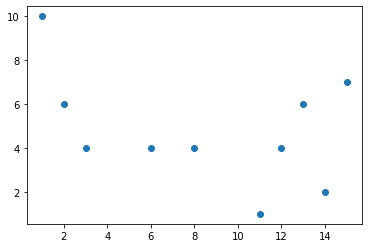

In [ ]:
plt.scatter(x, y)

In [ ]:
coeffs = np.polyfit(x, y, deg=9)
poly = np.poly1d(coeffs)

In [ ]:
x_fit = np.linspace(1, 15, 100)
y_fit = poly(x_fit)

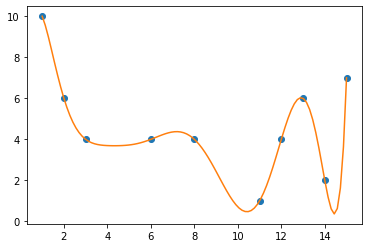

In [ ]:
plt.plot(x, y, 'o', x_fit, y_fit)

In [ ]:
def p(x):
    deg = 9
    y = 0
    for coeff in coeffs:
        y += (x ** deg) * coeff
        deg -= 1
    return y

In [ ]:
class OneCycle:
    def __init__(self, lr_max, div, div_final, pct_start, n_iters):
        self.lr_max = lr_max
        self.div = div
        self.div_final = div_final
        self.pct_start = pct_start
        self.n_iters = n_iters
        self.curr_iter = 0
        self.next_lr = lr_max / div
        self.turnaround = int(n_iters * (pct_start / 100))
        self.step_size = (lr_max - self.next_lr) / self.turnaround
    
    def curr_lr(self):
        lr = self.next_lr
        self.curr_iter += 1
        if self.curr_iter < self.turnaround:
            self.next_lr += self.step_size
        elif self.curr_iter > self.turnaround:
            self.next_lr -= self.step_size
        else:
            final_lr = self.lr_max / self.div_final
            self.step_size = (self.lr_max - final_lr) / (self.n_iters - self.turnaround - 1)
            self.next_lr = self.lr_max
        return lr

In [ ]:
import torch

In [ ]:
def find_stable_min(x):
    n_iters = 100
    one_cycle = OneCycle(lr_max=3, div=15, div_final=5, pct_start=70, n_iters=n_iters)

    x = torch.tensor(float(x)).requires_grad_()

    for i in range(n_iters):
        loss = p(x)
        lr = one_cycle.curr_lr()
        loss.backward()
        g = x.grad
        x = (x - g * lr).clone().detach().requires_grad_()
    
    return round(x.item(), 2), round(loss.item(), 2)

In [ ]:
starts = range(1, 16)

In [ ]:
for point in starts:
    found_min = find_stable_min(point)
    print(f'Minimum, when starting from {point} is: {found_min}')

Minimum, when starting from 1 is: (4.32, 3.69)
Minimum, when starting from 2 is: (4.32, 3.69)
Minimum, when starting from 3 is: (4.32, 3.69)
Minimum, when starting from 4 is: (4.32, 3.69)
Minimum, when starting from 5 is: (4.32, 3.69)
Minimum, when starting from 6 is: (4.32, 3.69)
Minimum, when starting from 7 is: (4.32, 3.69)
Minimum, when starting from 8 is: (4.32, 3.69)
Minimum, when starting from 9 is: (4.32, 3.69)
Minimum, when starting from 10 is: (4.32, 3.69)
Minimum, when starting from 11 is: (4.32, 3.69)
Minimum, when starting from 12 is: (4.32, 3.69)
Minimum, when starting from 13 is: (4.32, 3.69)
Minimum, when starting from 14 is: (4.32, 3.69)
Minimum, when starting from 15 is: (4.32, 3.69)
